In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt
from datetime import datetime

In [2]:
edge_df = pd.read_csv('dataset/fruitfly/condensed-edges.csv')
neuron_df = pd.read_csv('dataset/fruitfly/condensed-neurons.csv')

In [11]:
str2gt = {'000000000000000000000000000000800000000000000080': 1, '000000000000000000000000000000800000000000000040': 2, '0000000000000000000000000000000000000000000000c0': 0, '0000000000000000000000000000002000000000000000c0': 4, '000000000000004000000000000000800000000000000080': 5, '0000000000000020000000000000002000000000000000c0': 9, '0000000000000000000000000000008000000000000000c0': 3, '000000000000000000000000000000a000000000000000c0': 7, '000000000000004000000000000000a000000000000000c0': 11, '0000000000000040000000000000008000000000000000c0': 8, '0000000000000040000000000000002000000000000000c0': 10, '000000000000006000000000000000a000000000000000c0': 12, '000000000000004000000000000000200000000000000080': 6}


In [12]:
motif3_f = open('dataset/fruitfly/motif-size-003-certificates.txt', 'r')
line = motif3_f.readline()
motif_counts = [0 for i in range(13)]
while line:
    if ': ' in line:
        motif_id = str2gt[line.split(': ')[0]]
        motif_counts[motif_id] = int(line.split(': ')[1].strip())
    line = motif3_f.readline()    

# erdos ranyi graph, it cannot even generate all 13 types of size-3 motifs. Motif distribution omit.

In [3]:
rand_G = nx.erdos_renyi_graph(21739, 841720.0/(21739*21738), directed=True)


# configuration model

In [24]:
import random

G = nx.from_pandas_edgelist(edge_df, 'Pre Synaptic Neuron ID', 'Post Synaptic Neuron ID', create_using=nx.DiGraph)

indeg = [i[1] for i in G.in_degree]
outdeg = [i[1] for i in G.out_degree]
lamd = sum([i*j for i in indeg for j in outdeg])/len(G.edges)

rand_G = gt.Graph()
rand_G.add_vertex((len(indeg)))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G.add_edge(i,j)
rand_motif3 = gt.motifs(rand_G, 3)

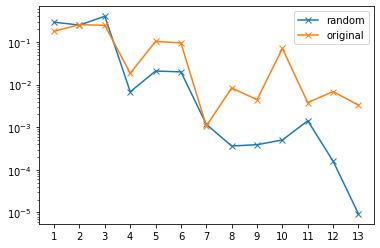

In [25]:
# nx2gt = {0:1, 1:2, 2:0, 3:4, 4:5, 5:9, 6:3, 7:7, 8:11, 9:8, 10:10, 11:12, 12:6}
plt.plot([str(i) for i in range(1,14)], [i/sum(rand_motif3[1]) for i in rand_motif3[1]],marker='x',label='random')
plt.plot([str(i) for i in range(1,14)], [motif_counts[i]/sum(motif_counts) for i in range(13)],marker='x',label='original')
plt.yscale('log')
plt.legend()

In [27]:
len(G.edges), len(G.nodes)

(841720, 21684)

In [26]:
output_g1 = nx.DiGraph()
for e in rand_G.edges():
    output_g1.add_edge(list(e)[0], list(e)[1])
nx.to_pandas_edgelist(output_g1, source='Pre Synaptic Neuron ID', target='Post Synaptic Neuron ID').to_csv('config_fly_condensed-edges.csv')

# Configuration model with two steps

In [5]:
import random

G = nx.from_pandas_edgelist(edge_df, 'Pre Synaptic Neuron ID', 'Post Synaptic Neuron ID', create_using=nx.DiGraph)
un_deg = [len([v for v in G[u] if u in G[v]]) for u in G.nodes]
# bidirection_edges = [ (u,v) for (u,v) in G.edges() if u in G[v] ]
# un_G = nx.Graph()
# un_G.add_edges_from(bidirection_edges)
# un_deg = [i[1] for i in un_G.degree]
# un_nodes = [i[0] for i in un_G.degree]

In [6]:
lamd = sum([un_deg[i]*un_deg[j] for j in range(len(un_deg)) for i in range(j+1, len(un_deg))])/(sum(un_deg)/2)

In [7]:
rand_G = gt.Graph()
rand_G.add_vertex((len(un_deg)))
for i in range(len(un_deg)):
    for j in range(i+1, len(un_deg)):
        if random.uniform(0, 1)<un_deg[i]*un_deg[j]/lamd:
            rand_G.add_edge(i,j)
            rand_G.add_edge(j,i)

In [8]:
indeg = [i[1] for i in G.in_degree]
outdeg = [i[1] for i in G.out_degree]

indeg = [indeg[i]-un_deg[i] for i in range(len(indeg))]
outdeg = [outdeg[i]-un_deg[i] for i in range(len(indeg))]

In [9]:
lamd = sum([i*j for i in indeg for j in outdeg])/(len(G.edges)-sum(un_deg))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and rand_G.edge(i,j) is None and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G.add_edge(i,j)

In [10]:
rand_motif3 = gt.motifs(rand_G, 3)

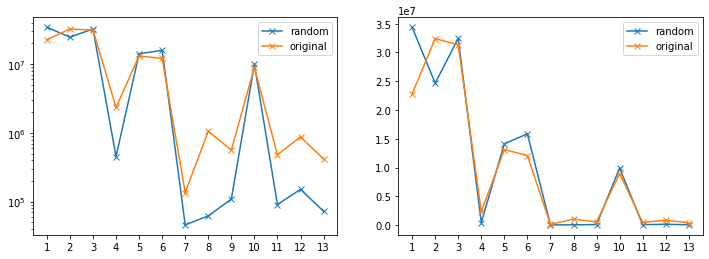

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[1].plot([str(i) for i in range(1,14)], [i for i in rand_motif3[1]],marker='x',label='random')
axs[1].plot([str(i) for i in range(1,14)], [motif_counts[i] for i in range(13)],marker='x',label='original')
axs[0].plot([str(i) for i in range(1,14)], [i for i in rand_motif3[1]],marker='x',label='random')
axs[0].plot([str(i) for i in range(1,14)], [motif_counts[i] for i in range(13)],marker='x',label='original')
axs[0].set_yscale('log')
axs[0].legend()
plt.legend()

In [22]:
output_g1 = nx.DiGraph()
for e in rand_G.edges():
    output_g1.add_edge(list(e)[0], list(e)[1])
nx.to_pandas_edgelist(output_g1, source='Pre Synaptic Neuron ID', target='Post Synaptic Neuron ID').to_csv('config_config_fly_condensed-edges.csv')

# Make reciprocal edges erdos ranyi

In [16]:
un_deg = [len([v for v in G[u] if u in G[v]]) for u in G.nodes]
bidirection_edges = [ (u,v) for (u,v) in G.edges() if u in G[v] ]
p = len(bidirection_edges)/(len(G.nodes)*(len(G.nodes)-1)/2)
rand_G2 = gt.Graph()
rand_G2.add_vertex((len(un_deg)))
for i in range(len(un_deg)):
    for j in range(i+1, len(un_deg)):
        if random.uniform(0, 1)<p:
            rand_G2.add_edge(i,j)
            rand_G2.add_edge(j,i)

In [17]:
# lamd = sum([i*j for i in indeg for j in outdeg])/(len(G.edges)-sum(un_deg))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and rand_G2.edge(i,j) is None and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G2.add_edge(i,j)

In [18]:
rand_motif3_2 = gt.motifs(rand_G2, 3)


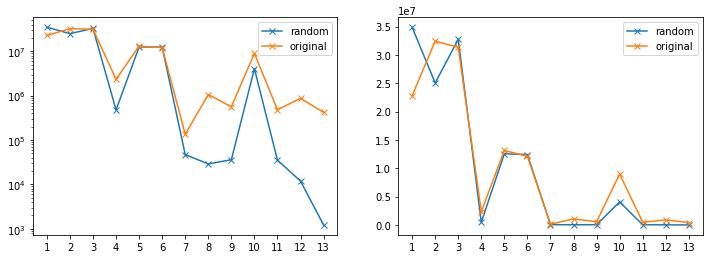

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[1].plot([str(i) for i in range(1,14)], [i for i in rand_motif3_2[1]],marker='x',label='random')
axs[1].plot([str(i) for i in range(1,14)], [motif_counts[i] for i in range(13)],marker='x',label='original')
axs[0].plot([str(i) for i in range(1,14)], [i for i in rand_motif3_2[1]],marker='x',label='random')
axs[0].plot([str(i) for i in range(1,14)], [motif_counts[i] for i in range(13)],marker='x',label='original')
axs[0].set_yscale('log')
axs[0].legend()
plt.legend()

In [34]:
len(bidirection_edges), len(G.edges), sum(un_deg)

(208418, 841720, 208418)

In [23]:
output_g1 = nx.DiGraph()
for e in rand_G2.edges():
    output_g1.add_edge(list(e)[0], list(e)[1])
nx.to_pandas_edgelist(output_g1, source='Pre Synaptic Neuron ID', target='Post Synaptic Neuron ID').to_csv('erdos_config_fly_condensed-edges.csv')